In [1]:
import numpy as np
import cv2
from glob import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parsuj dane i podziel na zbiór treningowy i testowy

In [2]:
process_data = False

# main_keys = [(['2021-04-19', '2021-05-08'], 'train'), (['2021-05-27'], 'test')]
main_keys = [(['2021-04-19', '2021-05-08', '2021-05-27'], 'full')]

keys = ['manipulowane', 'straty', 'zaklocajace', 'zaklocane']
data = pd.read_excel('./data/zmienne.xlsx', names=['a', 'b', 'c']).drop(columns=['a'])
mappsy = {'001NIR0SZR0.daca.pv': 'Straty łącznie'}
for ind, row in data.iterrows():
    mappsy[row.c] = row.b

if process_data:
    for dataset, tset in main_keys:
        for k in keys:
            df_list = []
            for dat in dataset:
                data = sorted(glob(f'data/dane/{dat}/{k}*'))
                for d in data:
                    df = pd.read_csv(d)
                    df_list.append(df)
            merged_df = pd.concat(df_list)
            merged_df.to_csv(f'data/{tset}_{k}.csv')

        df_manipulowane = pd.read_csv(f'data/{tset}_manipulowane.csv', index_col='Czas', parse_dates=True)
        df_manipulowane = df_manipulowane.drop(columns=['Unnamed: 0', 'Unnamed: 5'])
        # df_manipulowane.columns = ['mani_' + k for k in df_manipulowane.columns]

        df_straty = pd.read_csv(f'data/{tset}_straty.csv', index_col='czas', parse_dates=True)
        df_straty = df_straty.drop(columns=['Unnamed: 0'])
        # df_straty.columns = ['straty_' + k for k in df_straty.columns]

        df_zaklocajace = pd.read_csv(f'data/{tset}_zaklocajace.csv', index_col='Czas', parse_dates=True)
        df_zaklocajace = df_zaklocajace.drop(columns=['Unnamed: 0'])
        # df_zaklocajace.columns = ['zaklucaj_' + k for k in df_zaklocajace.columns]

        df_zaklocane = pd.read_csv(f'data/{tset}_zaklocane.csv', index_col='Czas', parse_dates=True)
        df_zaklocane = df_zaklocane.drop(columns=['Unnamed: 0', 'Unnamed: 5'])
        # df_zaklocane.columns = ['zaklucan_' + k for k in df_zaklocane.columns]

        m = pd.merge(df_manipulowane, df_straty, left_index=True, right_index=True)
        m = pd.merge(m, df_zaklocajace, left_index=True, right_index=True)
        m = pd.merge(m, df_zaklocane, left_index=True, right_index=True)

        m.columns = m.columns.map(mappsy)

        m.to_hdf(f'data/{tset}_merged.hdf', 'kej')

# df_train = pd.read_hdf(f'data/train_merged.hdf')
# df_test = pd.read_hdf(f'data/test_merged.hdf')
df = pd.read_hdf(f'data/full_merged.hdf')
df.shape

(3954000, 26)

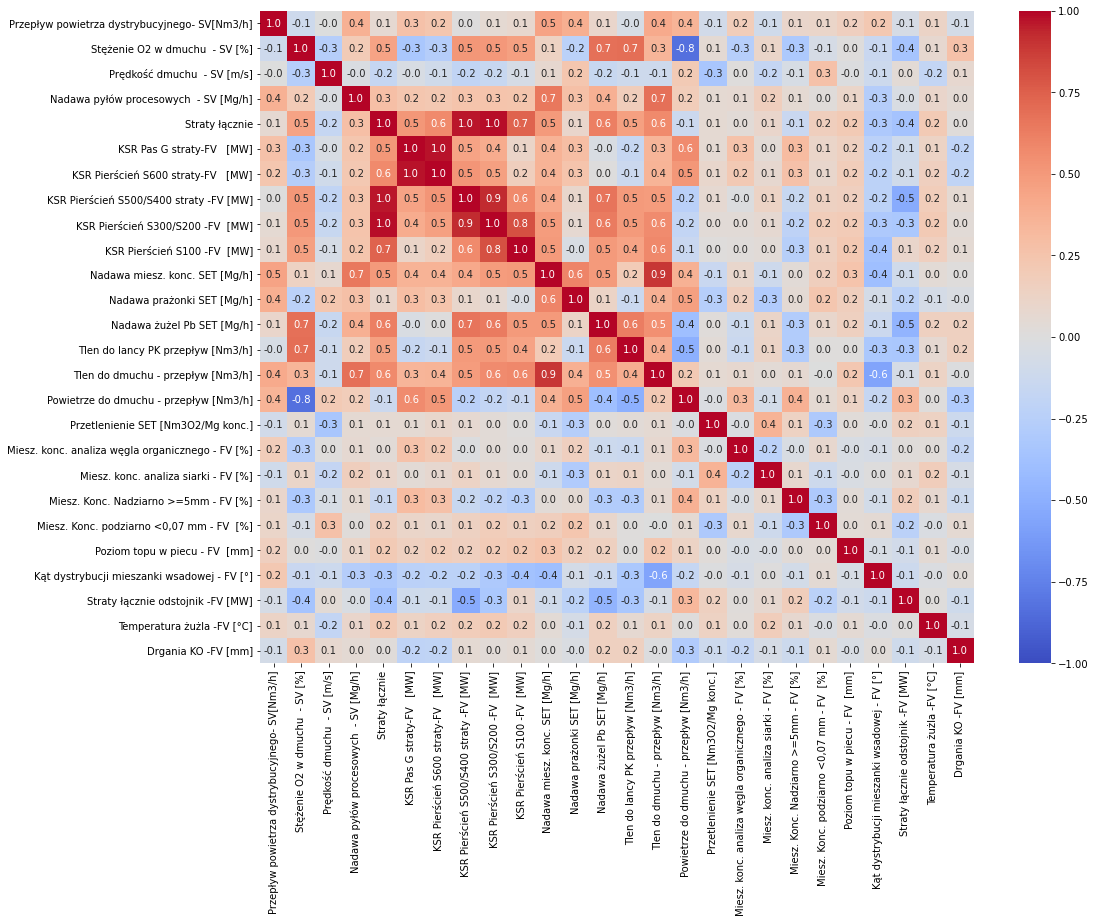

In [3]:
corr = df.corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1, annot=True, fmt='.1f');

In [4]:
df_train = df.iloc[:int(len(df)*0.8)]
df_test = df.iloc[int(len(df)*0.8):]
df_train.shape, df_test.shape

((3163200, 26), (790800, 26))

In [5]:
straty_columns = df_train.columns[[4,5,6,7,8,9]]
zadane_columns = df_train.columns[[0,1,2,3]]
# zaklucane_columns = df_train.columns[10:]
zaklucane_columns = df_train.columns[[22,23,24,25]]
zaklucajace_columns = df_train.columns[list(range(10,22))]

In [22]:
zadane_columns

Index(['Przepływ powietrza dystrybucyjnego- SV[Nm3/h]',
       'Stężenie O2 w dmuchu  - SV [%]', 'Prędkość dmuchu  - SV [m/s]',
       'Nadawa pyłów procesowych  - SV [Mg/h]'],
      dtype='object')

# Trenowanie modelu pieca zawiesinowego HMG

Train:  0.9437254894672221
Test:  -0.0635908280134505
MSE: 1.7510655609542614
MAE: 1.7510655609542614
MAE [%]: 0.09157791911715797


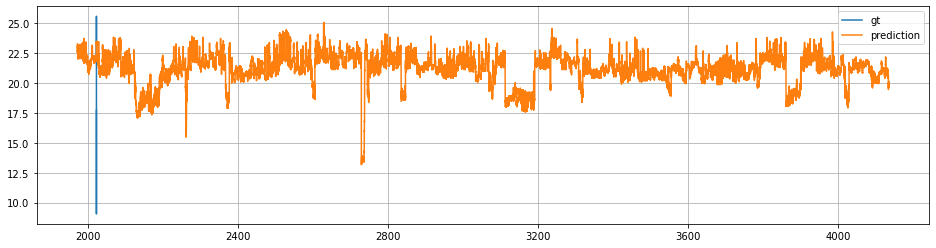

In [11]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

train_hmg = True

# X_train = np.concatenate((df_train[zadane_columns].values[1:], 
#                           df_train[zaklucajace_columns].values[1:], 
#                           df_train[zaklucane_columns].values[1:],
#                           df_train[straty_columns[0]].values[0:-1].reshape(-1,1)), axis=1)
X_train = np.concatenate((df_train[zadane_columns].iloc[59:], 
                          df_train[zaklucajace_columns].iloc[59:], 
                          df_train[zaklucane_columns].iloc[59:]), axis=1)
#                           df_train[straty_columns[0]].rolling(60).mean().dropna().values.reshape(-1,1)), axis=1)
y_train = df_train[straty_columns[0]].iloc[59:]

# X_test = np.concatenate((df_test[zadane_columns].values[1:], 
#                          df_test[zaklucajace_columns].values[1:], 
#                          df_test[zaklucane_columns].values[1:],
#                          df_test[straty_columns[0]].values[0:-1].reshape(-1,1)), axis=1)
X_test = np.concatenate((df_test[zadane_columns].iloc[59:], 
                         df_test[zaklucajace_columns].iloc[59:], 
                         df_test[zaklucane_columns].iloc[59:]), axis=1)
#                          df_test[straty_columns[0]].rolling(60).mean().dropna().values.reshape(-1,1)), axis=1)
y_test = df_test[straty_columns[0]].iloc[59:]

if train_hmg:
    hmg = LGBMRegressor()
    hmg.fit(X_train, y_train)
    
    joblib.dump(hmg, './models/hmg.pkl')
    
hmg = joblib.load('./models/hmg.pkl')

print('Train: ', hmg.score(X_train, y_train))
print('Test: ', hmg.score(X_test, y_test))

hmg_output = hmg.predict(X_test)

hmg_mae = mean_absolute_error(y_test, hmg_output)
hmg_mse = mean_squared_error(y_test, hmg_output)
hmg_mae_procent = mean_absolute_percentage_error(y_test, hmg_output)

print(f'MSE: {hmg_mae}')
print(f'MAE: {hmg_mae}')
print(f'MAE [%]: {hmg_mae_procent}')

plt.figure(figsize=(16,4));
plt.plot(y_test, label='gt');
plt.plot(hmg_output, label='prediction');
plt.legend();
plt.grid();

<AxesSubplot:>

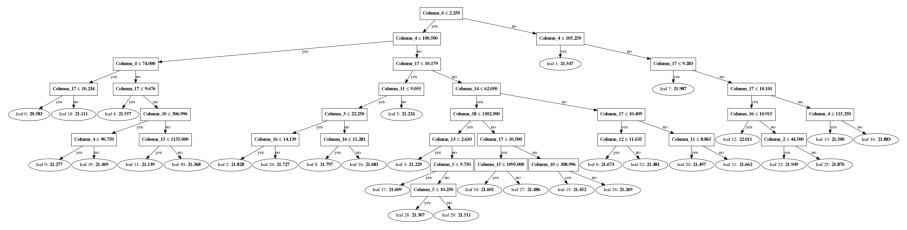

In [21]:
import lightgbm


lightgbm.plot_tree(hmg, figsize=(16,8), orientation='vertical')

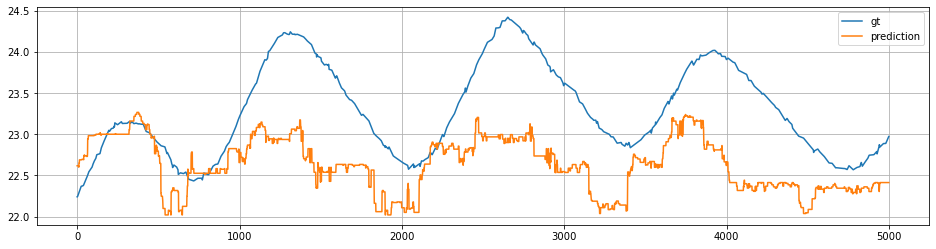

In [42]:
plt.figure(figsize=(16,4));
plt.plot(y_test[:5000], label='gt');
plt.plot(hmg_output[:5000], label='prediction');
plt.legend();
plt.grid();

In [99]:
mean_squared_error(y_test[1:], y_test[:-1]), mean_absolute_error(y_test[1:], y_test[:-1])

(1.4813618894201167e-05, 0.0020927273930116106)

In [22]:
y_data = y_test[0]

out = [y_data]*10
for x_data in tqdm(X_test):
    x = x_data[:-1]
    y_data = np.mean(out[-10].sum())
    x = np.array([*x, y_data], dtype=object).astype(float)
    y_data = hmg.predict([x])
    
    out.append(y_data[0])

100%|██████████| 790791/790791 [04:11<00:00, 3146.72it/s]


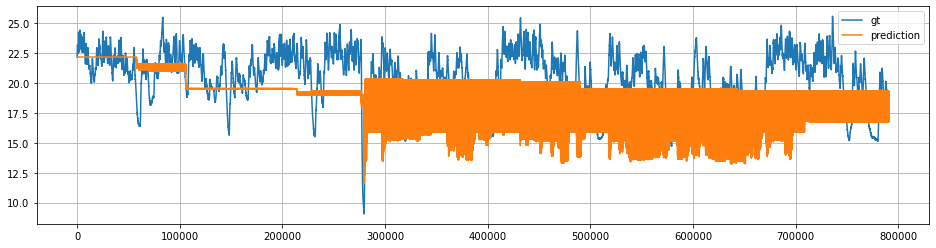

In [23]:
plt.figure(figsize=(16,4));
plt.plot(y_test, label='gt');
plt.plot(out, label='prediction');
plt.legend();
plt.grid();

In [25]:
mean_squared_error(y_test, out[9:-1]), mean_absolute_error(y_test, out[9:-1])

(18.956568751495666, 3.5923390747264716)

# Trenowanie modelu zmiennych zakłócanych

Train:  0.9670515509064368
Test:  0.93794517985444
MSE: [0.06053175 0.00371104 0.10795424 0.5477034 ]
MAE: [0.06053175 0.00371104 0.10795424 0.5477034 ]
MAE [%]: [2.83841835e-03 3.99658206e-04 8.52574449e-05 1.76594831e+00]


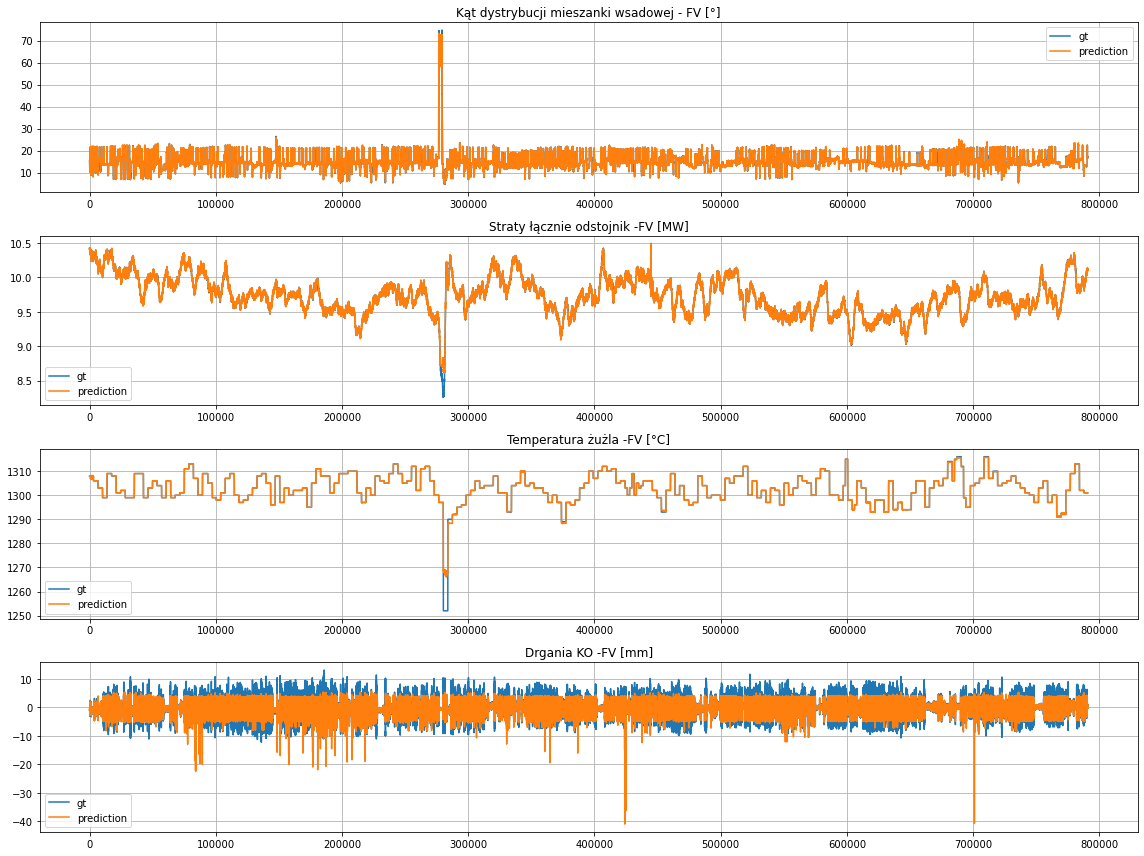

In [42]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

train_dummy_operator = False

X_train = np.concatenate((df_train[zadane_columns].values[1:], 
                          df_train[zaklucajace_columns].values[1:], 
                          df_train[zaklucane_columns].values[0:-1]), axis=1)
y_train = df_train[zaklucane_columns].values[1:]

X_test = np.concatenate((df_test[zadane_columns].values[1:], 
                         df_test[zaklucajace_columns].values[1:], 
                         df_test[zaklucane_columns].values[0:-1]), axis=1)
y_test = df_test[zaklucane_columns].values[1:]

if train_dummy_operator:
    reg = MultiOutputRegressor(LGBMRegressor())
    reg.fit(X_train,y_train)

    # save model
    joblib.dump(reg, './models/disturbed_variables_model.pkl')
    
# load model
disturbed_variables_model = joblib.load('./models/disturbed_variables_model.pkl')

print('Train: ', disturbed_variables_model.score(X_train, y_train))
print('Test: ', disturbed_variables_model.score(X_test, y_test))

output = disturbed_variables_model.predict(X_test)

mae = mean_absolute_error(y_test, output, multioutput='raw_values')
mse = mean_squared_error(y_test, output, multioutput='raw_values')
mae_procent = mean_absolute_percentage_error(y_test, output, multioutput='raw_values')

print(f'MSE: {mae}')
print(f'MAE: {mae}')
print(f'MAE [%]: {mae_procent}')

fig, ax = plt.subplots(4,1,figsize=(16,12));
for i in range(len(zaklucane_columns)):
    ax[i].set_title(zaklucane_columns[i]);
    ax[i].plot(y_test[:, i], label='gt');
    ax[i].plot(output[:, i], label='prediction');
    ax[i].legend();
    ax[i].grid();
plt.tight_layout()

# Trenowanie modelu imitacja sterowania operatora

Train:  0.9994942631658206
Test:  0.9966508223802482
MSE: [2.92992323 0.0167482  0.07824174 0.06983077]
MAE: [2.92992323 0.0167482  0.07824174 0.06983077]
MAE [%]: [0.00106194 0.00023281 0.00147458 0.00321272]


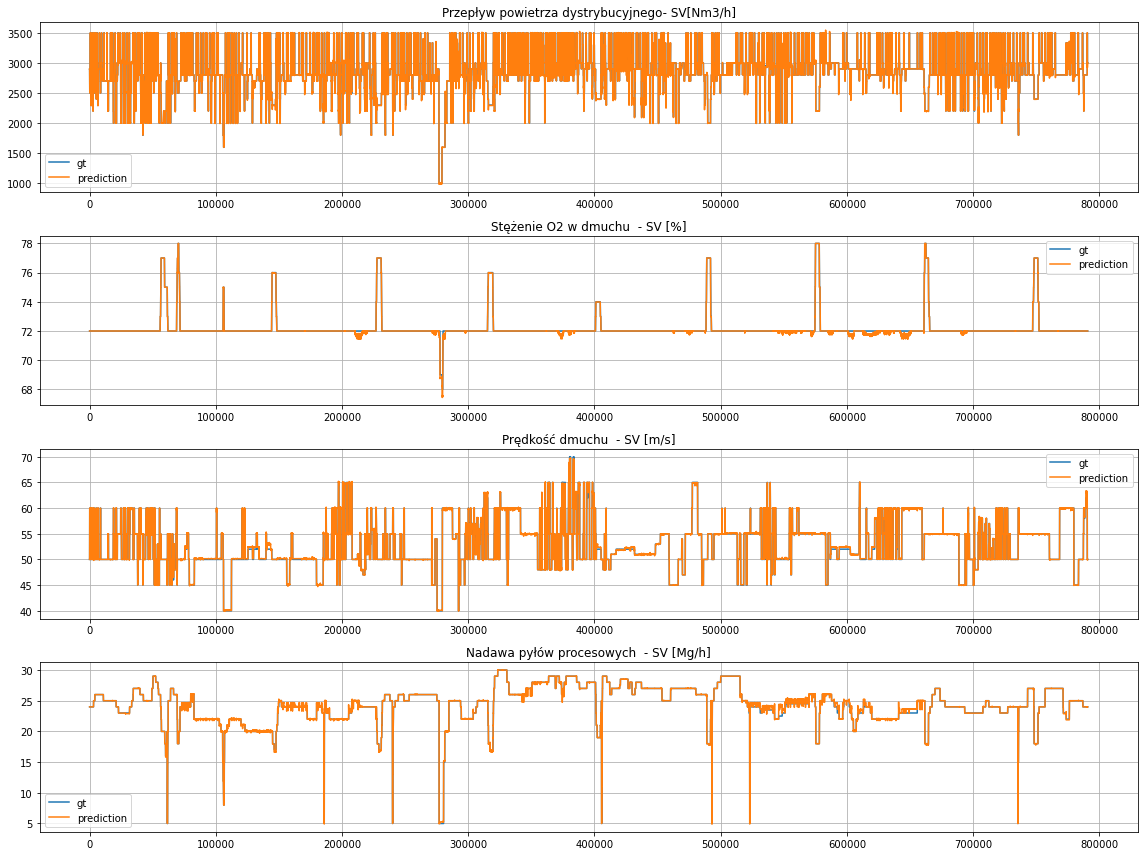

In [51]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
import joblib

train_dummy_operator = True

X_train = np.concatenate((df_train[zadane_columns].values[0:-1], 
                          df_train[zaklucajace_columns].values[1:], 
                          df_train[zaklucane_columns].values[1:]), axis=1)
y_train = df_train[zadane_columns].values[1:]

X_test = df_test[zaklucane_columns].values
X_test = np.concatenate((df_test[zadane_columns].values[0:-1], 
                         df_test[zaklucajace_columns].values[1:], 
                         df_test[zaklucane_columns].values[1:]), axis=1)
y_test = df_test[zadane_columns].values[1:]

if train_dummy_operator:
    reg = MultiOutputRegressor(LGBMRegressor())
    reg.fit(X_train,y_train)

    # save model
    joblib.dump(reg, './models/dummy_operator.pkl')
    
# load model
dummy_operator = joblib.load('./models/dummy_operator.pkl')
dummy_operator.score(X_test, y_test)

print('Train: ', dummy_operator.score(X_train, y_train))
print('Test: ', dummy_operator.score(X_test, y_test))

operator_output = dummy_operator.predict(X_test)

operator_mae = mean_absolute_error(y_test, operator_output, multioutput='raw_values')
operator_mse = mean_squared_error(y_test, operator_output, multioutput='raw_values')
operator_mae_procent = mean_absolute_percentage_error(y_test, operator_output, multioutput='raw_values')

print(f'MSE: {operator_mae}')
print(f'MAE: {operator_mae}')
print(f'MAE [%]: {operator_mae_procent}')

fig, ax = plt.subplots(4,1,figsize=(16,12));
for i in range(len(zadane_columns)):
    ax[i].set_title(zadane_columns[i]);
    ax[i].plot(y_test[:, i], label='gt');
    ax[i].plot(operator_output[:, i], label='prediction');
    ax[i].legend();
    ax[i].grid();
plt.tight_layout()

# Piec zawiesinowy HMG

In [21]:
class HMG:
    def __init__(self, model_path='./models/hmg.pkl'):
        self.hmg_model = joblib.load(model_path)
    
    def __call__(self, manipulated_variables, disturbing_variables, disturbed_variables, prev_furnace_state):
        # zmienne: manipulowane, zakłócające, zakłócane, poprzedni stan pieca
        input_parameters = np.concatenate([manipulated_variables, 
                                           disturbing_variables, 
                                           disturbed_variables, 
                                           prev_furnace_state])
             
        heat = self.hmg_model.predict([input_parameters])
        
        return heat[0]

# Model zmiennych zakłócanych

In [45]:
class DisturbedVariables:
    def __init__(self, model_path='./models/disturbed_variables_model.pkl'):
        self.disturbed_variables_model = joblib.load(model_path)
    
    def __call__(self, manipulated_variables, disturbing_variables, prev_disturbed_variables):
        # zmienne: manipulowane, zakłócające, zakłócane (poprzedni stan)
        input_parameters = np.concatenate([manipulated_variables, 
                                           disturbing_variables, 
                                           prev_disturbed_variables])
             
        disturbed_variables = self.disturbed_variables_model.predict([input_parameters])
        
        return disturbed_variables[0] 

In [48]:
manipulated_variables, disturbing_variables, prev_disturbed_variables = X_train[0, :4], X_train[0, 4:-4], X_train[0, -4:]
DisturbedVariables()(manipulated_variables, disturbing_variables, prev_disturbed_variables)

array([ 1.37407480e+01,  9.32996560e+00,  1.30599978e+03, -1.68129029e-01])

# Regulator z ograniczeniami

In [6]:
class Regulator:
    def __init__(self):
        # przepływ powietrza
        self.air_max_regulation = (1900, 3500)
        self.air_max_step = 800 # 
        self.air_min_time = 10 # sec
    
        # zawartość tlenu
        self.oxy_max_regulation = (65, 81)
        self.oxy_max_step = 2
        self.oxy_min_time = 150
        
        # dmuch
        self.puff_max_regulation = (40, 70)
        self.puff_max_step = 10
        self.puff_min_time = 5
        
        #pyły
        self.dust_max_regulation = (13, 27)
        self.dust_max_step = 13
        self.dust_min_time = 5*60
    
    def __call__(self, prev, new):
        prev_air, prev_oxy, prev_puff, prev_dust = prev
        new_air, new_oxy, new_puff, new_dust = new
        
        dest_air = prev_air
        dest_oxy = prev_oxy
        dest_puff = prev_puff
        dest_dust = prev_dust
        
        dest_air += np.min([np.abs(new_air), self.air_max_step]) * np.sign(new_air)
        dest_oxy += np.min([np.abs(new_oxy), self.oxy_max_step]) * np.sign(new_oxy)
        dest_puff += np.min([np.abs(new_puff), self.puff_min_time]) * np.sign(new_puff) 
        dest_dust += np.min([np.abs(new_dust), self.dust_min_time]) * np.sign(new_dust) 
        
        dest_air = np.clip(dest_air, *self.air_max_regulation)
        dest_oxy = np.clip(dest_oxy, *self.oxy_max_regulation)
        dest_puff = np.clip(dest_puff, *self.puff_max_regulation)
        dest_dust = np.clip(dest_dust, *self.dust_max_regulation)
        
        return dest_air, dest_oxy, dest_puff, dest_dust

reg = Regulator()
reg([1900,0,0, 23], [900,0,0,13])

(2700, 65, 40, 27)

# Regulator imitujący pracę operatora

In [22]:
class DummyOperator:
    def __init__(self, model_path='./models/dummy_operator.pkl'):
        self.dummy_operator_model = joblib.load(model_path)
    
    def __call__(self, prev_manipulated_variables, disturbing_variables, disturbed_variables):
        # zmienne: manipulowane (stan poprzedni), zakłócające, zakłócane
        input_parameters = np.concatenate([disturbing_variables, disturbed_variables])
             
        manipulated_variables = self.dummy_operator_model.predict([input_parameters])
        
        return manipulated_variables[0]

# Samooptymalizujący się model

In [63]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from tqdm import trange

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [70]:
# class DQN(nn.Module):

#     def __init__(self):
#         super(DQN, self).__init__()
#         self.head = nn.Linear(22, 4)

#     def forward(self, x):
#         x = torch.tensor(x, dtype=torch.float32)
#         return self.head(x)
# network = DQN()

network = torch.nn.Sequential(
    nn.Linear(22, 4)
)

In [71]:
optimizer = optim.RMSprop(network.parameters())

# TODO
criterion = nn.SmoothL1Loss()
# TODO

In [72]:
straty_columns = df_train.columns[[4,5,6,7,8,9]]
zadane_columns = df_train.columns[[0,1,2,3]]
zaklucane_columns = df_train.columns[10:]

In [78]:
steps = 1000
epochs = 400

state = df_train.iloc[0:1].copy()

for e in range(epochs):
    t = trange(steps, desc=f'{e+1}/{epochs} - Loss: ', leave=True)
    losses = []
    
    for i in t:

        without_zadane = state.drop(columns=zadane_columns)
        same_zadane = state[zadane_columns]

        mani_out = network(torch.tensor(without_zadane.values, dtype=torch.float32))

        mani_out_cpu = mani_out.detach().clone().numpy()
        mani_out_cpu = reg(same_zadane.values[0], mani_out_cpu[0])
        mani_out_cpu = pd.DataFrame([mani_out_cpu], columns=zadane_columns)

        new_state = state.copy()
        new_state[zadane_columns] = mani_out_cpu

        new_straty = world.predict(new_state.drop(columns=straty_columns))
        new_straty = pd.DataFrame(new_straty, columns=straty_columns)
        
        # TODO
        loss = criterion(torch.from_numpy(new_state[straty_columns].values), torch.from_numpy(new_straty.values))
        # TODO
        
        losses.append(loss.numpy())
        
        t.set_description(f'{e+1}/{epochs} - Loss: {np.mean(losses)}')
        t.refresh() # to show immediately the update

        optimizer.zero_grad()
        
        # TODO
    #     loss.backward()
    #     optimizer.step()
        # TODO

        k = np.random.choice(np.arange(df_train.shape[0]))
        state = df_train.iloc[k:k+1].copy()

4/400 - Loss: 0.12739864967608464:  16%|█▌        | 156/1000 [00:01<00:10, 80.72it/s]


KeyboardInterrupt: 